In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf

## Data import
import numpy as np
import mne

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from keras import backend as K

In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

2022-06-27 15:19:46.035993: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 15:19:47.963708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4860 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-06-27 15:19:47.964700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4860 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5
2022-06-27 15:19:47.965506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 

In [ ]:
'''!pip install gdown

!gdown https://drive.google.com/drive/folders/14VyrNeh6sNsdG9fPNxCDsCWeglRUiGW2?usp=sharing --fuzzy -O A01E.gdf
!gdown https://drive.google.com/file/d/15-XziDALmff18eUCOOEiQV6LYxM5n-QD/view?usp=sharing --fuzzy -O A01T.gdf

!gdown https://drive.google.com/file/d/15yvwE5U7CL1D8upqP5ZDt_-qwllfnqt0/view?usp=sharing --fuzzy -O A02E.gdf
!gdown https://drive.google.com/file/d/15wMYomAJ7wZORTzoXv4e-ANoFqyj4FJk/view?usp=sharing --fuzzy -O A02T.gdf

!gdown https://drive.google.com/file/d/15ylKfImuURvJqp2RsimJNd7nbpHM7wwQ/view?usp=sharing --fuzzy -O A03E.gdf
!gdown https://drive.google.com/file/d/16-7nDsmroOg6GPo7YHbKRY0L-SYq7ngr/view?usp=sharing --fuzzy -O A03T.gdf

!gdown https://drive.google.com/file/d/15cUP6PS8bUPjwONmIH2yB9WRvs7jSl1f/view?usp=sharing --fuzzy -O A04E.gdf
!gdown https://drive.google.com/file/d/15PAKHivqm90VXj8D2icmJFU5St9d-bSG/view?usp=sharing --fuzzy -O A04T.gdf

!gdown https://drive.google.com/file/d/15Fv6JylDBxxSJXRU1kHO7J9w4eng1p-w/view?usp=sharing --fuzzy -O A05E.gdf
!gdown https://drive.google.com/file/d/15dAzq7hm-bMBdAkVthAuPZjsOU4ezAi6/view?usp=sharing --fuzzy -O A05T.gdf

!gdown https://drive.google.com/file/d/159RRQ99cXg_7nT3s78uFFeTsmx_3-13X/view?usp=sharing --fuzzy -O A06E.gdf
!gdown https://drive.google.com/file/d/157L4Mb84IjsyHhKs3S_kkf-fPS-t-EA_/view?usp=sharing --fuzzy -O A06T.gdf

!gdown https://drive.google.com/file/d/157b_TYeVwD8OzKk0IcKCPcvTF_fN6FVo/view?usp=sharing --fuzzy -O A07E.gdf
!gdown https://drive.google.com/file/d/158rlHr3Km2BW5XSM9IXsTDb5H2OQLl6m/view?usp=sharing --fuzzy -O A07T.gdf

!gdown https://drive.google.com/file/d/15USJQ5mgdyGHU_PYx-W47WBG6ajVTFQD/view?usp=sharing --fuzzy -O A08E.gdf
!gdown https://drive.google.com/file/d/159h_ugVgzzJk6y80ijdhSZig7eiIFLT7/view?usp=sharing --fuzzy -O A08T.gdf

!gdown https://drive.google.com/file/d/15LoUTuKukUbH-nAWWH4W5AOhjHbEyjTh/view?usp=sharing --fuzzy -O A09E.gdf
!gdown https://drive.google.com/file/d/15suXLYadd-5o5526mlCU9AVma6lIquKd/view?usp=sharing --fuzzy -O A09T.gdf
'''

In [3]:
folder_path_string = "BCICIV_2a_gdf/"

file_path_string = folder_path_string + "A01T.gdf"
evaluation_path_string = folder_path_string + "A01T.evt"

raws = []

In [4]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
raw_fname = file_path_string
event_fname = evaluation_path_string
tmin, tmax = -0., 1

# Setup for reading the raw data
raw = mne.io.read_raw_gdf(raw_fname)
raw.load_data()

#original filter
raw.filter(2, None, method='iir')  # replace baselining with high-pass

events, event_ids = mne.events_from_annotations(raw)
event_id = events[1]
print("event_id ",event_id)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)

# Read epochs
stims =[value for key, value in event_ids.items() if key in ('769','770','771','772')]
epochs = mne.Epochs(raw, events, stims, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
channels_to_remove = ['EOG-left', 'EOG-central', 'EOG-right']
epochs = epochs.drop_channels(channels_to_remove)
labels = epochs.events[:, -1]
print(epochs)

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels
y[y == 7] = 0
y[y == 8] = 1
y[y == 9] = 2
y[y == 10] = 3

kernels, chans, samples = 1, X.shape[1], X.shape[2]

# take 50/25/25 percent of the data to train/validate/test

train_idx = round(X.shape[0] * 0.5)
test_idx = round(X.shape[0] * 0.75)

X_train      = X[0:train_idx,]
Y_train      = y[0:train_idx]
X_validate   = X[train_idx:test_idx,]
Y_validate   = y[train_idx:test_idx]
X_test       = X[test_idx:,]
Y_test       = y[test_idx:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
y_unique = np.unique(y)
num_classes = len(y_unique)
Y_train      = np_utils.to_categorical(Y_train-1, num_classes=num_classes)
Y_validate   = np_utils.to_categorical(Y_validate-1, num_classes=num_classes)
Y_test       = np_utils.to_categorical(Y_test-1, num_classes=num_classes)

# convert data to NHWC (trials, channels, samples, kernels) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print("X.Shape", X.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print("y.Shape", y.shape)
print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('num_classes:', num_classes)

Extracting EDF parameters from /home/jovyan/work/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/opt/conda/lib/python3.9/site-packages/mne/io/edf/edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
/opt/conda/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
event_id  [0 0 3]
<Epochs |  288 events (all good), 0 - 1 sec, baseline off, ~12.2 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>
X.Shape (288, 22, 251)
X_train shape: (144, 22, 251, 1)
X_test shape: (72, 22, 251, 1)
y.Shape (288,)
y_train shape: (144, 4)
y_test shape: (72, 4)
144 train samples
72 test samples
num_classes: 4


In [5]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling2D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

2022-06-27 15:19:59.417474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4860 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:01:00.0, compute capability: 7.5
2022-06-27 15:19:59.418056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 4860 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:25:00.0, compute capability: 7.5
2022-06-27 15:19:59.418606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 4860 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:81:00.0, compute capability: 7.5
2022-06-27 15:19:59.419153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 4860 MB memory:  -> device: 3, name: Quadro RTX 8000, pci bus id: 0000:c7:00.0, compute 

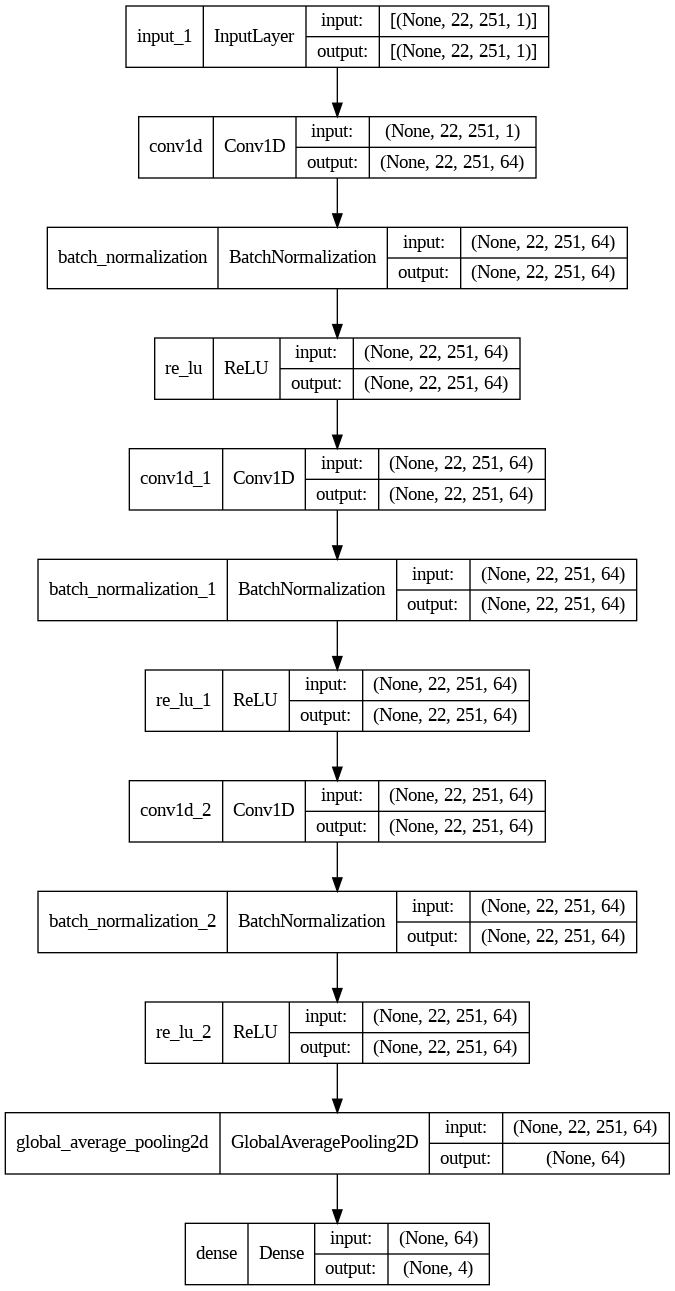

In [6]:
model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [18]:
epochs = 100
batch_size = 16 #32

checkpointer = keras.callbacks.ModelCheckpoint(filepath='tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy', 'TruePositives', 'TrueNegatives'])

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=checkpointer,
    validation_data=(X_validate, Y_validate), #validation_split=0.2,
    verbose=2, #1
)

Epoch 1/100


2022-06-27 15:19:04.667593: E tensorflow/stream_executor/cuda/cuda_dnn.cc:371] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-06-27 15:19:04.667669: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at conv_ops.cc:1120 : UNKNOWN: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.


UnknownError: 2 root error(s) found.
  (0) UNKNOWN:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_2/conv1d_6/Conv1D/Conv2D
 (defined at /opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py:231)
]]
	 [[assert_less_equal/Assert/AssertGuard/pivot_f/_13/_29]]
  (1) UNKNOWN:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_2/conv1d_6/Conv1D/Conv2D
 (defined at /opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py:231)
]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_8946]

Errors may have originated from an input operation.
Input Source operations connected to node model_2/conv1d_6/Conv1D/Conv2D:
In[0] model_2/conv1d_6/Conv1D/Reshape:	
In[1] model_2/conv1d_6/Conv1D/ExpandDims_1:

Operation defined at: (most recent call last)
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_57357/3540209697.py", line 11, in <module>
>>>     history = model.fit(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

Input Source operations connected to node model_2/conv1d_6/Conv1D/Conv2D:
In[0] model_2/conv1d_6/Conv1D/Reshape:	
In[1] model_2/conv1d_6/Conv1D/ExpandDims_1:

Operation defined at: (most recent call last)
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "/opt/conda/lib/python3.9/asyncio/events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
>>>     if await self.run_code(code, result, async_=asy):
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_57357/3540209697.py", line 11, in <module>
>>>     history = model.fit(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "/opt/conda/lib/python3.9/site-packages/keras/layers/convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

Function call stack:
train_function -> train_function


## Evaluate model on test data

In [9]:
# load optimal weights
model.load_weights('tmp/checkpoint.h5')

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

3/3 [==============================] - 0s 73ms/step
Classification accuracy: 0.236111 
